In [1]:
seed = 2
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import sys
sys.path.append("/home/webphy/Desktop/dnn_processor_v2/")  # just to enable `dataset`
sys.path.append("/home/webphy/Desktop/dnn_processor_v2/dataset/")  # just to enable `dataset`

import dataset
import plotting
import qkeras
import keras

2024-02-15 19:05:24.717817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 19:05:24.740691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 19:05:24.740716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 19:05:24.741502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 19:05:24.745736: I tensorflow/core/platform/cpu_feature_guar

In [2]:
BATCH_SIZE = 64
train_images_rgx = "../dataset/train_set/*/*.jpeg"
valid_images_rgx = "../dataset/test_set/*/*.jpeg"

train_ds, val_ds, nclasses = dataset.create_datasets(
    train_images_rgx, valid_images_rgx, BATCH_SIZE, 128
)

2024-02-15 19:05:26.042171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 19:05:26.065079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 19:05:26.065222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from qkeras.utils import load_qmodel
from qkeras.estimate import print_qstats

model_path = "../neural_network/quantization/qatwqkeras/saved_qmodels/qatwqkeras.h5"

qmodel = load_qmodel(
    model_path,
    compile=False,
)
qmodel.compile(
    "adam", loss=tf.keras.losses.CategoricalCrossentropy(True), metrics=["accuracy"]
)

score = qmodel.evaluate(val_ds)
print("Accuracy: {}".format(score[1]))

print_qstats(qmodel)

/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-02-15 19:05:30.588491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


10/10 [==============================] - 3s 23ms/step - loss: 0.2990 - accuracy: 0.8967
Accuracy: 0.8967136144638062
Instructions for updating:
Use ref() instead.


/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 196608 (smult_8_8)
    q_conv2d_1                    : 129600 (smult_8_8)
    q_conv2d_2                    : 18000 (smult_8_8)
    q_dense                       : 5625  (smult_4_4)

Number of operation types in model:
    smult_4_4                     : 5625
    smult_8_8                     : 344208

Weight profiling:
    q_conv2d_weights               : 192   (8-bit unit)
    q_conv2d_bias                  : 4     (8-bit unit)
    q_conv2d_1_weights             : 576   (8-bit unit)
    q_conv2d_1_bias                : 16    (8-bit unit)
    q_conv2d_2_weights             : 80    (8-bit unit)
    q_conv2d_2_bias                : 5     (8-bit unit)
    q_dense_weights                : 5625  (4-bit unit)
    q_dense_bias                   : 5     (8-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.0204
    q_conv2d_1                     : 0.0152
    q_conv2d_2                     

In [4]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    qmodel,
    granularity="name",
    default_precision="fixed<32,16>",
    default_reuse_factor=9000,
)

config["Model"]["Strategy"] = "Resource"

for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Strategy"] = "Resource"



Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 15, 15, 5]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Resh

/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)
/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [5]:
plotting.print_dict(config)

Model
  Precision:         fixed<32,16>
  ReuseFactor:       9000
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_1
    Trace:           False
    Precision
      result:        fixed<32,16>
    Strategy:        Resource
  q_activation
    Trace:           False
    Precision
      result:        ufixed<8,0,RND_CONV,SAT>
    Strategy:        Resource
  q_conv2d
    Trace:           False
    Precision
      result:        fixed<32,16>
      weight:        fixed<8,1>
      bias:          fixed<8,1>
    Strategy:        Resource
  q_conv2d_linear
    Trace:           False
    Precision
      result:        fixed<32,16>
    Strategy:        Resource
  q_activation_1
    Trace:           False
    Precision
      result:        ufixed<8,0,RND_CONV,SAT>
    Strategy:        Resource
  q_conv2d_1
    Trace:           False
    Precision
      result:        fixed<32,16>
      weight:        fixed<8,1>
      bias:          fixed<8,1>

In [6]:

hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=config,
    output_dir=f"manualqat/hls4ml_prj",
    part="xc7z020-clg400-1",
    io_type="io_stream",
)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 15, 15, 5]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Resh

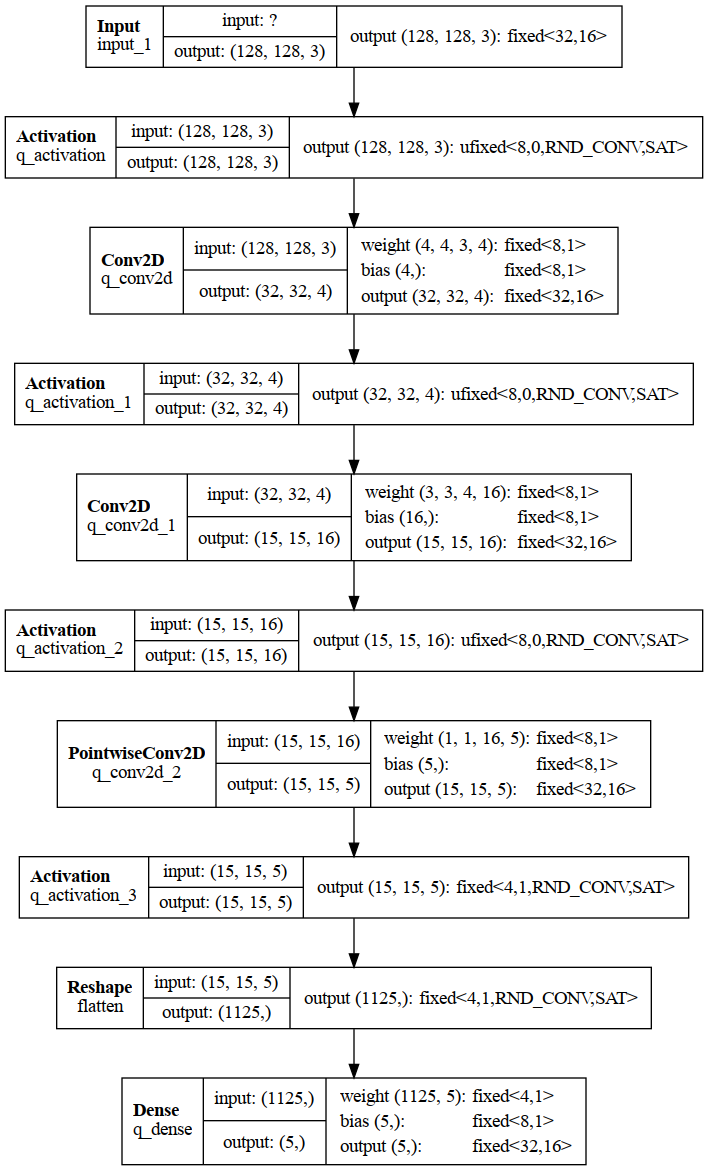

In [7]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [8]:
hls_model.compile()

/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [12]:
classes = ["acf_alv", "acf_chap", "reboco", "tijolo_alv", "tijolo_chap"]
X_test = np.load("../dataset/x_test_set.npy")
y_test = np.load("../dataset/y_test_set.npy")

y_qkeras = tf.nn.softmax(qmodel.predict(np.ascontiguousarray(X_test)), axis=-1).numpy()
y_hls = tf.nn.softmax(hls_model.predict(np.ascontiguousarray(X_test)), axis=-1).numpy()

np.save('manualqat/y_qkeras.npy', y_qkeras)
np.save('manualqat/y_hls.npy', y_hls)

20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 2ms/step
Accuracy baseline:  0.9139280125195618
Accuracy pruned, quantized: 0.8967136150234741
Accuracy hls4ml: 0.8967136150234741


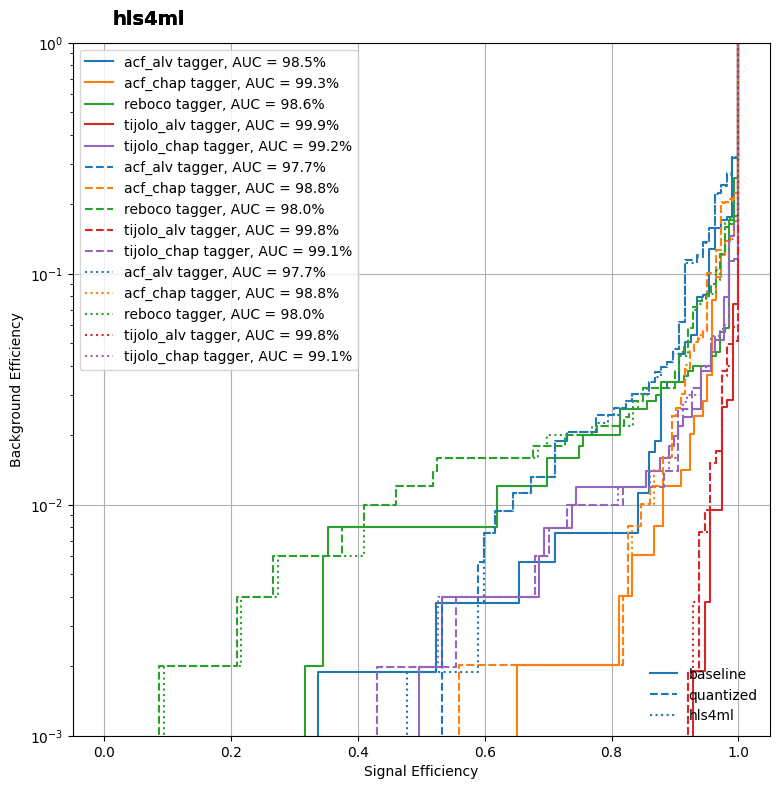

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model_ref = keras.models.load_model(
    "../neural_network/handmade/saved_models/baseline_model_v2/best_model_t/model_clean.h5"
)
y_ref = tf.nn.softmax(model_ref.predict(X_test), axis=-1).numpy()

print(
    "Accuracy baseline:  {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
    )
)
print(
    "Accuracy pruned, quantized: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))
    )
)
print(
    "Accuracy hls4ml: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle="--")
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=":")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--"), Line2D([0], [0], ls=":")]
from matplotlib.legend import Legend

leg = Legend(
    ax,
    lines,
    labels=["baseline", "quantized", "hls4ml"],
    loc="lower right",
    frameon=False,
)
ax.add_artist(leg)

In [14]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'webphy' on host 'wesley-XPS-8950' (Linux_x86_64 version 6.5.0-17-generic) on Thu Feb 15 19:16:02 -03 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.3 LTS
INFO: [HLS 200-10] In directory '/home/webphy/Desktop/dnn_processor_v2/hls4ml/manualqat/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/webphy/Desktop/dnn_processor_v2/hls4ml/manualqat/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '6.464',
  'BestLatency': '3293171',
  'WorstLatency': '3293578',
  'IntervalMin': '81922',
  'IntervalMax': '3293186',
  'BRAM_18K': '106',
  'DSP': '0',
  'FF': '30386',
  'LUT': '46005',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

In [15]:
hls4ml.report.read_vivado_report(f"manualqat/hls4ml_prj")

Found 1 solution(s) in manualqat/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Thu Feb 15 19:17:23 2024

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 6.464 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-------+---------+----------+
    |  Latency (cycles) |   Latency (absolute)  |     Interval    | Pipeline |
    |   min   |   max   |    min    |    max    |  min  |   max   |   Type   |
    +---------+-----

# build for PYNQ

In [16]:
output_dir=f"deploy/manualqat/hls4ml_prj"

hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=config,
    output_dir=output_dir,
    part="xc7z020-clg400-1",
    io_type="io_stream",
    backend='VivadoAccelerator',
    board='pynq-z2'
)

hls_model.compile()
hls_model.build(csim=False, export=True, bitfile=True)

/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 15, 15, 5]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Resh

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '6.464',
  'BestLatency': '3293174',
  'WorstLatency': '3293581',
  'IntervalMin': '475138',
  'IntervalMax': '3293186',
  'BRAM_18K': '202',
  'DSP': '0',
  'FF': '33489',
  'LUT': '52753',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.213,
  'TNS': 0.0,
  'WHS': 0.01,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [17]:
hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in deploy/manualqat/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Thu Feb 15 19:20:05 2024

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 6.464 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+--------+---------+----------+
    |  Latency (cycles) |   Latency (absolute)  |     Interval     | Pipeline |
    |   min   |   max   |    min    |    max    |   min  |   max   |   Type   |
    +-